In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
region = 'Thphotopeak'
df = pd.HDFStore('pmaps_corrected_{}_6206.h5'.format(region))['']

# 2. Corrected energy spectra overview

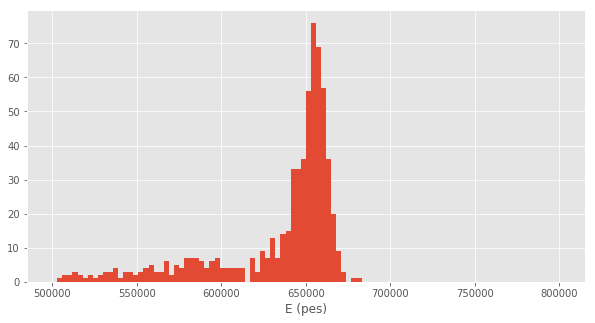

In [4]:
Emax = 800e3
Emin = 500e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

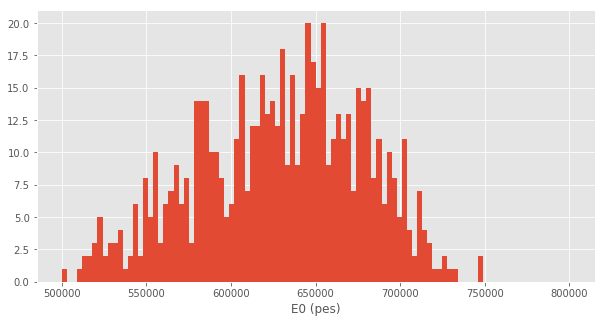

In [5]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

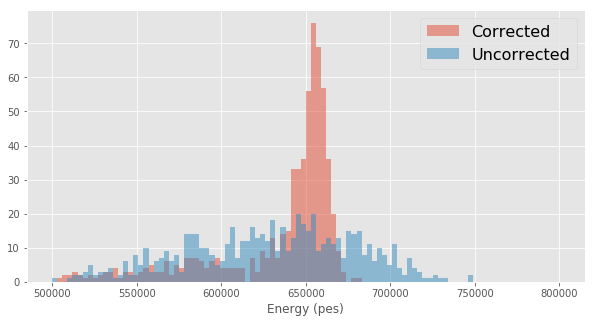

In [6]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

# 3. Select region

In [7]:
Emax = 680e3
Emin = 600e3

In [8]:
df = df[(df.e<Emax) & (df.e>Emin)]

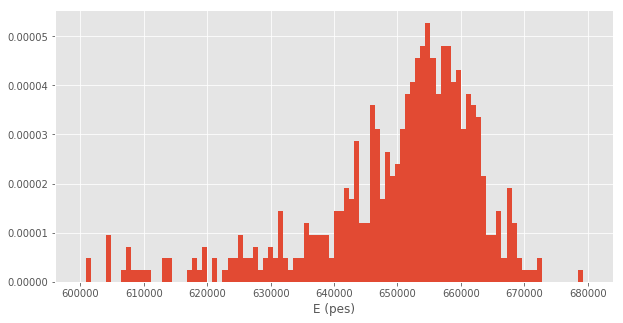

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(df['e'], bins=nbins, range = (Emin,Emax), density=True);
plt.xlabel('E (pes)', fontsize=12);

# 4. Fitting photopeak

We perform a gaussian fit for the photopeak and assume a linear fit for background

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2} + m(E-E_{min}) + c$$

For an unbined fit, F(E) should be converted to a density probability function so the degrees of freedom (parameters) reduce to one less than the initial.

In [11]:
#def cte(Eph, sig, A, m):
#    return -(A*(2*np.pi)**.5*sig + m*(Emax-Emin)**2)/(Emax-Emin)

#def F(E, Eph, sig, A, m):
#    c = cte(Eph, sig, A, m)
#    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def F(E, Eph, sig):
    A = 1/(2*np.pi*sig**2)**.5
    E = np.array(E)
    return A * np.e**(-(E-Eph)**2/(2*sig**2))

#def chisq(F, popt, xdata, ydata):
#    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

def likelihood(param, *E):
    return -2*np.log10(np.sum(F(E,*param)))

def jacobian(param, *E):
    Eph = param[0]
    sig = param[1]
    
    E = np.array(E)
    
    jac_Eph = -F(E, Eph, sig)*(E-Eph)/sig**2
    jac_sig = F(E, Eph, sig)*(-1/sig + (E-Eph)**2/sig**3)

    return np.array([jac_Eph, jac_sig])

In [12]:
E = tuple(df['e'])

#guess = [np.mean(df['e']), np.std(df['e']), np.max(ydata), -1]
guess = [np.mean(df['e']), np.std(df['e'])]

res = optimize.minimize(likelihood, guess, E, jac = jacobian, 
                        bounds = [(-np.inf, np.inf), (0, np.inf)])
Eph, sig = res.x

error: failed in converting 7th argument `g' of _lbfgsb.setulb to C/Fortran array

In [12]:
res

      fun: 3.8666562222174226
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16351373e-05,  3.90798505e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([650007.48523469,  13376.07864542])

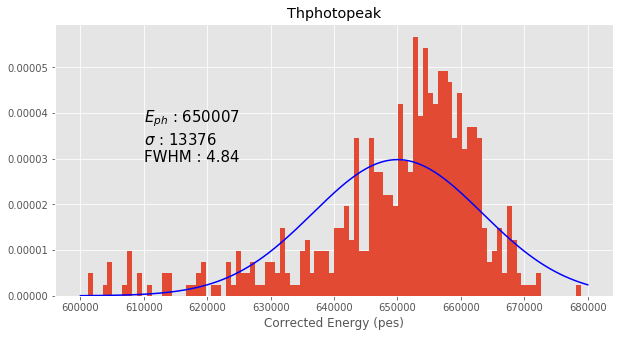

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(df['e'], bins=nbins, density=True);
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *res.x), color = 'b');

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 
     #"\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(610e3, 3e-5, s = t, fontsize = 15);
ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(region));

In [14]:
print('Extrapolated FWHM:',sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 2.509668579530247


# 5. Searching correlations

## 5.1. Corrected Energy correlations

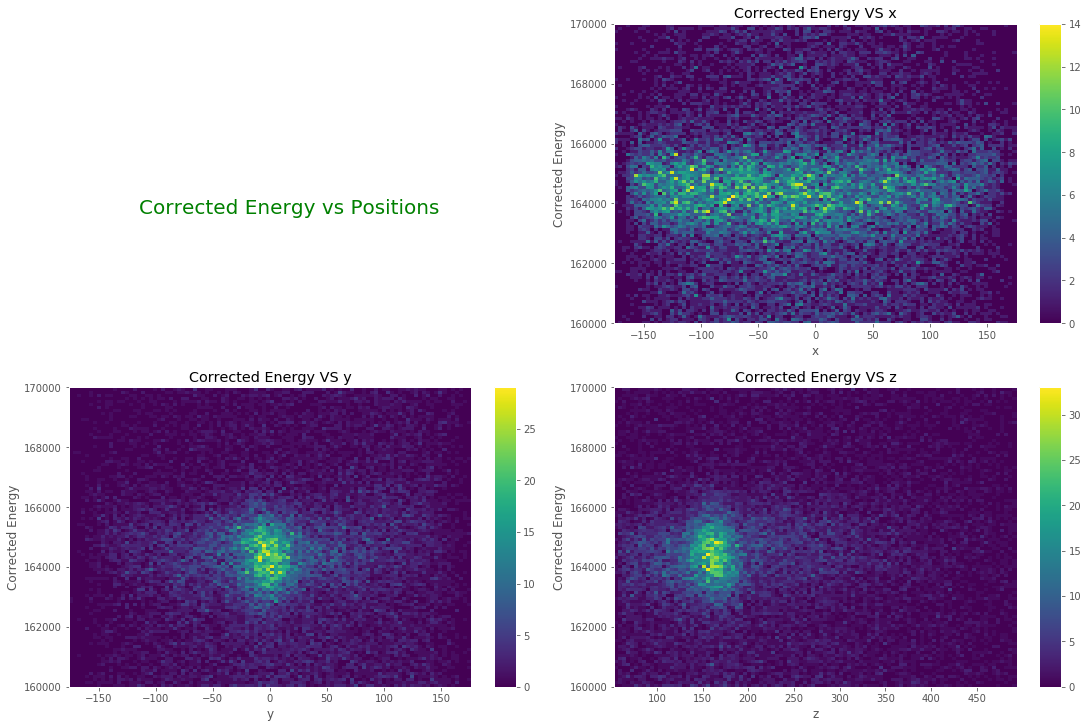

In [15]:
fig_ep = plt.figure(figsize =[15, 10] ,constrained_layout=True)

gs_ep = gridspec.GridSpec(2, 2, figure=fig_ep)

textpos = gs_ep[0, 0].get_position(fig_ep).get_points()
plt.figtext(textpos[0,0], (textpos[0,1] + textpos[1, 1])/2., 
            s='Corrected Energy vs Positions', figure=fig_ep, fontsize=20, color='green')

ax_ex = fig_ep.add_subplot(gs_ep[0, 1])
hist_ex = ax_ex.hist2d(df['x'], df['e'] , bins=nbins);
ax_ex.set_xlabel('x');
ax_ex.set_ylabel('Corrected Energy');
ax_ex.set_title('Corrected Energy VS x');
cbar_ex = fig_ep.colorbar(hist_ex[3], ax = ax_ex)

ax_ey = fig_ep.add_subplot(gs_ep[1, 0])
hist_ey = ax_ey.hist2d(df['y'], df['e'] , bins=nbins);
ax_ey.set_xlabel('y');
ax_ey.set_ylabel('Corrected Energy');
ax_ey.set_title('Corrected Energy VS y');
cbar_ey = fig_ep.colorbar(hist_ey[3], ax = ax_ey)

ax_ez = fig_ep.add_subplot(gs_ep[1, 1])
hist_ez = ax_ez.hist2d(df['z'], df['e'] , bins=nbins);
ax_ez.set_xlabel('z');
ax_ez.set_ylabel('Corrected Energy');
ax_ez.set_title('Corrected Energy VS z');
cbar_ez = fig_ep.colorbar(hist_ez[3], ax = ax_ez)

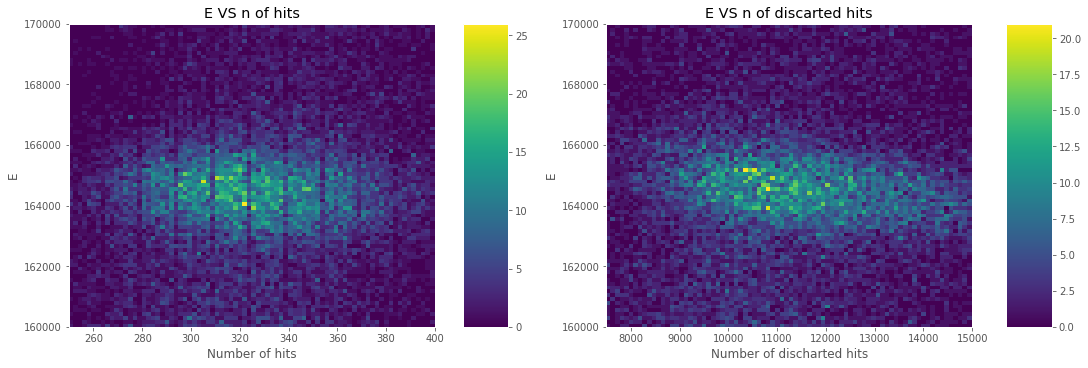

In [16]:
fig_e = plt.figure(figsize=[15, 5], constrained_layout=True)

gs_e = gridspec.GridSpec(1, 2, figure=fig_e)

ax_enhits = fig_e.add_subplot(gs_e[0])
hist_enhits = ax_enhits.hist2d(df['nhits'], df['e'] , bins=.8*nbins, range=((250, 400),(Emin, Emax)));
ax_enhits.set_xlabel('Number of hits');
ax_enhits.set_ylabel('E');
ax_enhits.set_title('E VS n of hits');
cbar_enhits = fig_e.colorbar(hist_enhits[3], ax = ax_enhits)

ax_enoqhits = fig_e.add_subplot(gs_e[1])
hist_enoqhits = ax_enoqhits.hist2d(df['noqhits'], df['e'] , bins=.8*nbins, range=((7.5e3, 15e3), (Emin, Emax)));
ax_enoqhits.set_xlabel('Number of discharted hits');
ax_enoqhits.set_ylabel('E');
ax_enoqhits.set_title('E VS n of discarted hits');
cbar_enoqhits = fig_e.colorbar(hist_enoqhits[3], ax = ax_enoqhits)

### 5.1.1. E vs Number of Slices

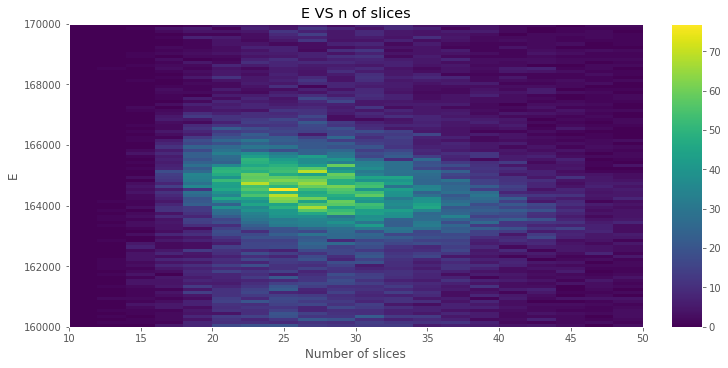

In [17]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df['nslices'], df['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

In [18]:
## Profile construction
cut    = 100 #cut for the number of entries in each slice
n_merg = 5   #size of the group of slices to merge

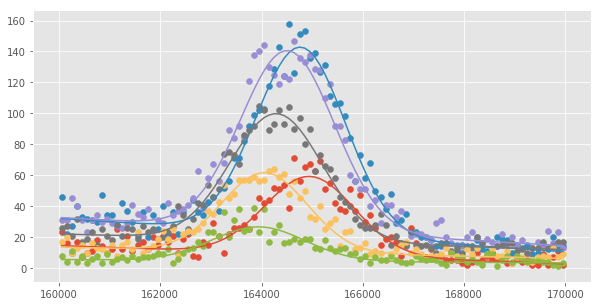

In [19]:
nslices_raw = np.unique(df['nslices'])

#Cut in number of slices
nslices = []
for nsl in nslices_raw:
    if len(df[df.nslices == nsl])<cut:
        continue
    else: nslices.append(nsl)
nslices = np.array(nslices)

nslices_merged = np.array([nslices[n_merg*i:n_merg*(i+1)] for i in range(0, int(len(nslices)/n_merg))])

profile = pd.DataFrame(columns=['nslices', 'Eph', 'sig', 'chisq'])
for nslices in nslices_merged:
    cdf = df[(df.nslices >= nslices[0]) & ((df.nslices <= nslices[-1]))]
    
    #Fitting
    ydata, xdata = np.histogram(cdf['e'], bins=nbins, range = (Emin,Emax))
    xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

    guess = [np.mean(cdf['e']), np.std(cdf['e']), np.max(ydata), -1, np.mean(ydata)]
    popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata))
    chi = chisq(F, popt, xdata, ydata)
    
    Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]
    
    nsl = np.sum(nslices)/len(nslices)
    profile = profile.append({'nslices': nsl, 'Eph': Eph, 'sig': sig, 'chisq': chi}, ignore_index=True)
    
    plt.scatter(xdata, ydata)
    plt.plot(xdata, F(xdata, *popt))

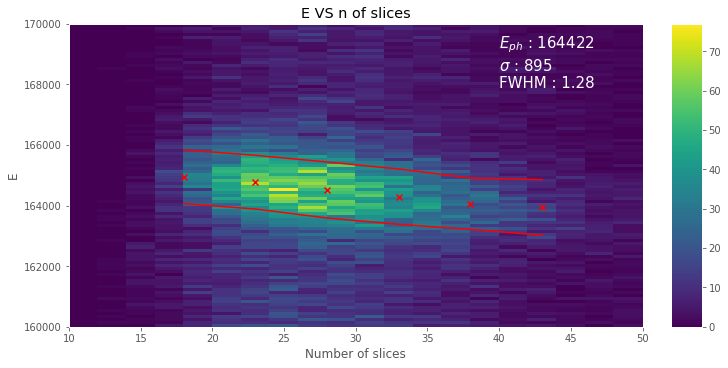

In [27]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df['nslices'], df['e'] , bins=[.2*nbins, nbins], range=((10, 50),(Emin, Emax)));
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_e.colorbar(hist_enslices[3], ax = ax_enslices)

ax_enslices.scatter(profile['nslices'], profile['Eph'], marker='x', color='r');

ax_enslices.plot(profile['nslices'], profile['Eph'] + profile['sig'], color='r');
ax_enslices.plot(profile['nslices'], profile['Eph'] - profile['sig'], color='r');


Eph = profile['Eph'].mean()
sig = profile['sig'].mean()
t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig))  +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2))) 

ax_enslices.text(40, 168e3, s = t, fontsize = 15, color='white');

In [21]:
profile

,nslices,Eph,sig,chisq
0,18.0,164953.377738,886.639662,1.621811
1,23.0,164772.458007,886.928267,1.133399
2,28.0,164514.665399,923.651651,1.140511
3,33.0,164294.111089,913.822971,0.753033
4,38.0,164062.073304,846.617459,1.068709
5,43.0,163939.895710,918.068998,1.252351


In [22]:
Eph = profile['Eph'].mean()
sig = profile['sig'].mean()

In [23]:
print('Extrapolated FWHM:', sig/Eph * 235 * (662/2458)**.5)

Extrapolated FWHM: 0.6645537173881788


## 5.2. Other Correlations

### 5.2.1 Number of slices

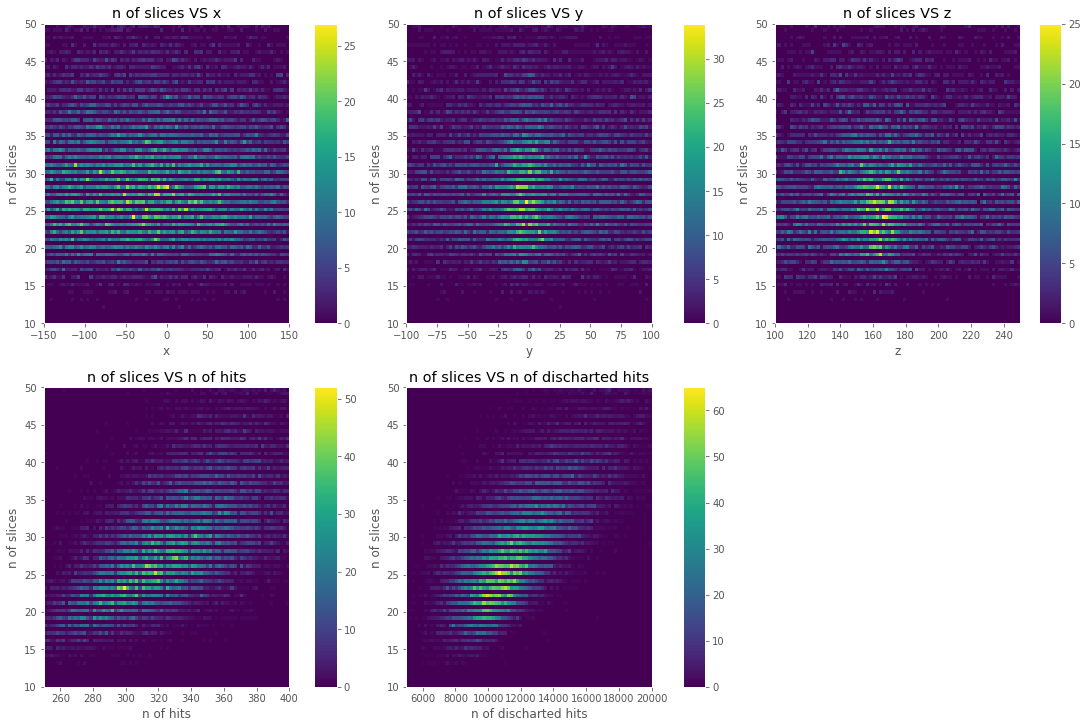

In [53]:
fig_nsl = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_nsl = gridspec.GridSpec(2, 3, figure=fig_nsl)

ax_nslx = fig_nsl.add_subplot(gs_nsl[0,0])
hist_nslx = ax_nslx.hist2d(df['x'], df['nslices'] , bins=.8*nbins, range=((-150, 150),(10, 50)));
ax_nslx.set_xlabel('x');
ax_nslx.set_ylabel('n of slices');
ax_nslx.set_title('n of slices VS x');
cbar_nslx = fig_e.colorbar(hist_nslx[3], ax = ax_nslx)

ax_nsly = fig_nsl.add_subplot(gs_nsl[0,1])
hist_nsly = ax_nsly.hist2d(df['y'], df['nslices'] , bins=.8*nbins, range=((-100, 100),(10, 50)));
ax_nsly.set_xlabel('y');
ax_nsly.set_ylabel('n of slices');
ax_nsly.set_title('n of slices VS y');
cbar_nsly = fig_nsl.colorbar(hist_nsly[3], ax = ax_nsly)

ax_nslz = fig_nsl.add_subplot(gs_nsl[0,2])
hist_nslz= ax_nslz.hist2d(df['z'], df['nslices'] , bins=.8*nbins, range=((100, 250),(10, 50)));
ax_nslz.set_xlabel('z');
ax_nslz.set_ylabel('n of slices');
ax_nslz.set_title('n of slices VS z');
cbar_nslz = fig_nsl.colorbar(hist_nslz[3], ax = ax_nslz);

ax_nslnh = fig_nsl.add_subplot(gs_nsl[1,0])
hist_nslnh= ax_nslnh.hist2d(df['nhits'], df['nslices'] , bins=.8*nbins, range=((250, 400),(10, 50)));
ax_nslnh.set_xlabel('n of hits');
ax_nslnh.set_ylabel('n of slices');
ax_nslnh.set_title('n of slices VS n of hits');
cbar_nslnh= fig_nsl.colorbar(hist_nslnh[3], ax = ax_nslnh);

ax_nslnoh = fig_nsl.add_subplot(gs_nsl[1,1])
hist_nslnoh= ax_nslnoh.hist2d(df['noqhits'], df['nslices'] , bins=.8*nbins, range=((5e3, 20e3),(10, 50)));
ax_nslnoh.set_xlabel('n of discharted hits');
ax_nslnoh.set_ylabel('n of slices');
ax_nslnoh.set_title('n of slices VS n of discharted hits');
cbar_nslnoh= fig_nsl.colorbar(hist_nslnoh[3], ax = ax_nslnoh);

# 6. Other distributions

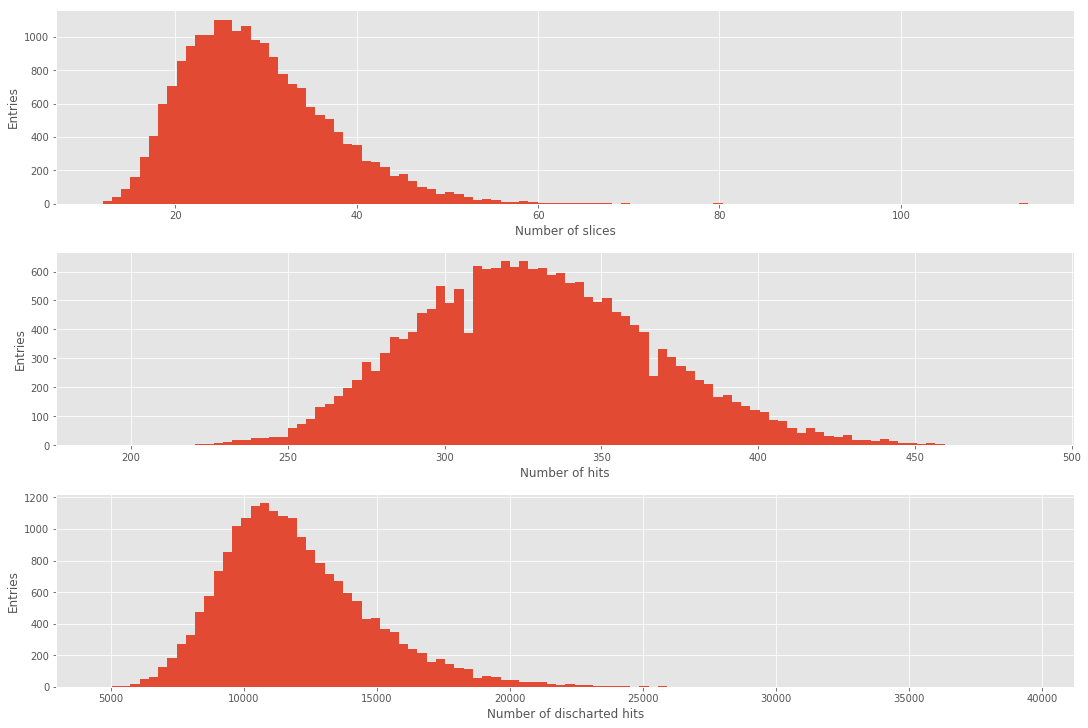

In [54]:
fig_d = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_d = gridspec.GridSpec(3, 1, figure=fig_d)

ax_nsl = fig_d.add_subplot(gs_d[0]);
hist_nsl = ax_nsl.hist(df['nslices'] , bins=nbins);
ax_nsl.set_xlabel('Number of slices');
ax_nsl.set_ylabel('Entries');

ax_nh = fig_d.add_subplot(gs_d[1]);
hist_nh = ax_nh.hist(df['nhits'] , bins=nbins);
ax_nh.set_xlabel('Number of hits');
ax_nh.set_ylabel('Entries');

ax_noh = fig_d.add_subplot(gs_d[2]);
hist_noh = ax_noh.hist(df['noqhits'] , bins=nbins);
ax_noh.set_xlabel('Number of discharted hits');
ax_noh.set_ylabel('Entries');